# <h2>Importación de librerias</h2>

In [1]:
# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Operational Libraries
import pandas as pd
import re
import dask.dataframe as dd
import numpy as np

# <h2>1. Carga de datos desde excel a dataframes de pandas</h2>


En primer lugar voy a cargar cada uno de los csv a unos dataframes de pandas para ir manejandolos desde aqui. La idea es ir cruzando algunos excels y ver qué graficos interesantes van saliendo de los datos que tenemos. Los voy a cargar todos de una vez y a continuación los veremos en tablas para ir describiendolos

Esto puede tomar un ratito

In [2]:
df_tratamiento = pd.read_csv('Tratamiento.csv')

In [3]:
df_informacion_de_clientes = pd.read_csv('Informacion_Clientes.csv')

In [4]:
df_simulaciones_clientes = pd.read_csv('Simulaciones_Clientes.csv')

In [5]:
df_ventas = pd.read_csv('Ventas.csv')

In [6]:
df_simulaciones_clientes[df_simulaciones_clientes['Monto_Simulado'] < 0].count()
df_simulaciones_clientes = df_simulaciones_clientes[df_simulaciones_clientes['Monto_Simulado'] > 0]


<h3>1.1 Carga de 'Informacion_Clientes.csv'</h3>

En primer lugar se cargará la información de los clientes. Esto incluye las siguientes características de los clientes:

* **unnamed**: algo como uid
* **Rut**: identificador de Chile (supongo que por privacidad va desde 0 a max de observaciones)
* **Género**: Masculino o femenino
* **Categoría_Digital**: Si el cliente es digital o no
* **Elasticidad_Precios**: Baja, media o alta
* **Nacionalidad**: Chileno o extranjero
* **Propensión**: Número entre 0 y 1 que idica que tan propenso a cursar un credito es el cliente
* **Probabilidad_No_Pago**: Número entre 0 y 1 que indica la probabilidad de que el cliente no pague la deuda
* **Edad**: Numero entero de edad en años
* **Renta**: Renta promedio de los últimos 12 meses
* **Oferta_Consumo**: Monto máximo que puede cursar un cliente dado sus antecedentes crediticios y situación socioeconómica. 
* **Deuda_CMF**: Deuda que tiene el cliente en otros bancos. Efectivamente es deuda pendiente, pero de créditos otorgados por la competencia.
* **Tiempo_como_cliente**: Número de tiempo(no sé en que medida está) que el cliente lleva en el banco


In [7]:
# df_informacion_de_clientes['Genero'].nunique()

In [8]:
# tiempo_como_cliente_maximo = df_informacion_de_clientes['Tiempo_como_cliente'].max()
# tiempo_como_cliente_minimo =df_informacion_de_clientes['Tiempo_como_cliente'].max()
# print(f'Tiempo máximo como cliente: {tiempo_como_cliente_maximo}\nTiempo mínimo como cliente: {tiempo_como_cliente_minimo}')

<span style="color:cyan">Algo interesante es que tiempo como cliente es solamente '2'</span>

In [9]:
df_informacion_de_clientes.drop(columns=['Tiempo_como_cliente'], inplace=True)

<h3>1.2 Carga de 'Simulaciones_Clientes.csv'</h3>

En segundo lugar se cargaran las simulaciones hechas por los clientes en la página del banco. Esto incluye las siguientes características de las simulaciones:
* **unnamed**: Supongo que es el número de simulacion registrada, un tipo de identificador de la simulación
* **fecha**: yyyy-mm-dd fecha de la simulación
* **rut**: identificador de Chile del cliente que hizo la simulacion
* **monto_simulado**: monto prestado al cliente
* **plazo_simulado**: plazo en **meses** del crédito
* **tasa_simulado**: costo para el cliente del credito

Lo interesante es que con el rut se pueden cruzar el dataframe de informacion de cliente y del plazo simulado

<h3>1.3 Carga de 'Tratamiento.csv'</h3>

En tercer lugar se cargara el tratamiento que ha tenido el banco con el cliente, es decir, cómo se han contactado con él. Esto incluye las siguientes características:

* **unnamed**: Número de tratamiento registrado
* **fecha**: yyyy-mm-dd
* **rut**: Identificador de Chile del cliente con el que se tiene el tipo de trato
* **n_correos**: Cantidad de correos que se enviaron en el mes que sale la fecha. Es decir, si sele fecha '2024-03-01', correspondería a los correos enviados en marzo de 2024.
* **asg_ejec**: Si el cliente tiene un ejecutivo asignado

-[Notas de jp]: Este es el que más me costo entender, está registrado el tratamiento por fecha. Hay muchos más tratamientos(3 millones y medio) que clientes(500 mil clientes) por lo que supongo que el tipo de trato que le dan al cliente pudo haber cambiado en el tiempo. No estoy seguro si la cantidad de correos es un recuento del total de correos hasta la fecha o cuantos se les envió esa fecha.

<h3>1.4 Carga de 'Ventas.csv'</h3>

Por último se cargaran las ventas que ha tenido el banco con el cliente. Esto incluye las siguientes características:

* **unnamed**: Índice sin significado
* **fecha**: yyyy-mm-dd -> fecha en la que se concretó la venta
* **rut**: identificador de Chile del cliente al que se le concretó la venta

# <h2>2. Joints de datos<h2>


Ya con todos los df cargados se pueden ir cruzando algunos de ellos para poder ir sacando algunas conclusiones.

El primer joint que haré es la informacion de los clientes y la simulacion. 

Quiero saber: de todos mis clientes quienes son los que simulan. Por lo tanto, para cada uno de los clientes que exista en la base de informacion de clientes quiero tener la informacion de sus simulaciones (o no simulaciones es que no han simulado). Esto es interesante para saber si simulan o no.

In [10]:
df_simulaciones_e_informacion_de_clientes = pd.merge(
    df_informacion_de_clientes, 
    df_simulaciones_clientes, 
    on='rut', 
    how='left')

Revisaremos si hay algun NaN en este merge, es decir, si algún cliente no ha simulado.

In [11]:
df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].isna().sum()

747

In [12]:
df_simulaciones_e_informacion_de_clientes[df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].isna()]['rut'].nunique()

747

<span style="color:cyan">Hay 747 personas que nunca simularon.</span>

Esto lo agregaré como columna llamada simulo, que es binaria e indica si el cliente simuló o no.


In [13]:
df_simulaciones_e_informacion_de_clientes['simulo'] = df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].notna().astype(int)

In [14]:
df_simulaciones_e_informacion_de_clientes.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], inplace=True)

In [15]:
df_simulaciones_e_informacion_de_clientes_ventas = pd.merge( 
    df_simulaciones_e_informacion_de_clientes, 
    df_ventas, 
    on=['rut', 'fecha'], 
    how='left'
    )

# 3. Procesamiento de tablas para ilan [ 1 ]
Tabla 1 (Ganancias): Necesito una tabla con todas las ventas, que tenga:

- fecha
- ⁠id cliente
- ⁠probabilidad no pago de ese cliente
- ⁠tasa
- ⁠monto
- ⁠plazo

In [16]:
df_simulaciones_e_informacion_de_clientes_ventas

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,Unnamed: 0
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-10-01,319936.0,33.0,1.092295,1,NaN
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2019-11-01,249773.0,30.0,2.324675,1,NaN
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2020-02-01,280087.0,28.0,1.051704,1,7864773.0
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-05-01,289780.0,26.0,2.193118,1,NaN
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,712585.357842,2021-06-01,258061.0,22.0,2.188368,1,7864775.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-03-01,403331.0,17.0,2.356028,1,NaN
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2023-08-01,359897.0,16.0,2.478376,1,NaN
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-03-01,348048.0,18.0,2.301079,1,NaN
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,574575.649505,2024-05-01,344504.0,16.0,2.462272,1,3871677.0


In [17]:
df_simulaciones_e_informacion_de_clientes_filtered = df_simulaciones_e_informacion_de_clientes_ventas[df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna()]
tabla_ganancias = df_simulaciones_e_informacion_de_clientes_filtered[['rut','Probabilidad_No_Pago','Tasa_Simulado','fecha','Monto_Simulado','Plazo_Simulado']].copy()

tabla_ganancias

,rut,Probabilidad_No_Pago,Tasa_Simulado,fecha,Monto_Simulado,Plazo_Simulado
2,1,0.028445,1.051704,2020-02-01,280087.0,28.0
4,1,0.028445,2.188368,2021-06-01,258061.0,22.0
8,1,0.028445,2.343216,2022-08-01,249106.0,34.0
10,1,0.028445,2.358720,2023-04-01,236814.0,32.0
12,1,0.028445,1.203271,2023-10-01,286611.0,24.0
...,...,...,...,...,...,...
8517073,543651,0.019647,1.282082,2021-05-01,363738.0,18.0
8517077,543651,0.019647,1.103655,2022-06-01,316063.0,15.0
8517079,543651,0.019647,2.337312,2023-02-01,386646.0,16.0
8517083,543651,0.019647,2.462272,2024-05-01,344504.0,16.0


# 3.2 Procesamiento de tablas para ilan [ 2 ]
Tabla 2 (créditos y correos): Necesito que me envíes por mes una tabla con:

- id cliente
- ⁠mes
- ⁠créditos simulados
- ⁠créditos aprobados
- ⁠correos enviados
- asignacion de ejecutivo

In [18]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento = pd.merge( 
    df_simulaciones_e_informacion_de_clientes_ventas, 
    df_tratamiento, 
    on=['rut', 'fecha'], 
    how='left'
    )

In [21]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.rename(columns={'Unnamed: 0_x': 'venta'}, inplace=True)
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['venta'] = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['venta'].notna().astype(int)
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,...,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,venta,Unnamed: 0_y,n_correos,asg_ejec,mes
0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,2019-10-01,319936.0,33.0,1.092295,1,0,0.0,2.0,0.0,2019-10
1,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,2019-11-01,249773.0,30.0,2.324675,1,0,0.0,0.0,0.0,2019-11
2,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,2020-02-01,280087.0,28.0,1.051704,1,1,0.0,1.0,0.0,2020-02
3,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,2021-05-01,289780.0,26.0,2.193118,1,0,0.0,1.0,0.0,2021-05
4,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,625818.326221,2164276.0,...,2021-06-01,258061.0,22.0,2.188368,1,1,0.0,3.0,0.0,2021-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517080,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,2023-03-01,403331.0,17.0,2.356028,1,0,543650.0,2.0,1.0,2023-03
8517081,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,2023-08-01,359897.0,16.0,2.478376,1,0,543650.0,2.0,0.0,2023-08
8517082,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,2024-03-01,348048.0,18.0,2.301079,1,0,543650.0,4.0,0.0,2024-03
8517083,543651,Femenino,Cliente no Digital,Media,Chileno,0.860781,0.019647,35.0,472806.728024,1979540.0,...,2024-05-01,344504.0,16.0,2.462272,1,1,543650.0,0.0,1.0,2024-05


In [22]:
df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['mes'] = pd.to_datetime(df_simulaciones_e_informacion_de_clientes_ventas_tratamiento['fecha']).dt.to_period('M')

tabla_creditos_correos = df_simulaciones_e_informacion_de_clientes_ventas_tratamiento.groupby(['rut', 'mes']).agg({
    'Monto_Simulado': 'count',
    'venta': 'sum',
    'n_correos': 'sum',
    'asg_ejec': 'max'
}).reset_index()

tabla_creditos_correos.rename(columns={
    'rut': 'id cliente',
    'Monto_Simulado': 'créditos simulados',
    'venta': 'créditos aprobados',
    'n_correos': 'correos enviados',
    'asg_ejec': 'asignacion de ejecutivo'
}, inplace=True)

tabla_creditos_correos

,id cliente,mes,créditos simulados,créditos aprobados,correos enviados,asignacion de ejecutivo
0,1,2019-10,1,0,2.0,0.0
1,1,2019-11,1,0,0.0,0.0
2,1,2020-02,1,1,1.0,0.0
3,1,2021-05,1,0,1.0,0.0
4,1,2021-06,1,1,3.0,0.0
...,...,...,...,...,...,...
8516333,543651,2023-03,1,0,2.0,1.0
8516334,543651,2023-08,1,0,2.0,0.0
8516335,543651,2024-03,1,0,4.0,0.0
8516336,543651,2024-05,1,1,0.0,1.0


In [23]:
tabla_creditos_correos.to_csv('df_to_ilan_2_with_ejec.csv', index=False)


KeyboardInterrupt: 

In [61]:
df_informacion_de_clientes.to_csv('df_informacion_de_clientes_updaetd.csv', index=False)

# 3.5 Tratamiento on venta

In [28]:
df_clientes_que_no_simulan = df_simulaciones_e_informacion_de_clientes[df_simulaciones_e_informacion_de_clientes['simulo'] == 0]
df_clientes_que_no_simulan

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,fecha,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo
12137,780,Femenino,Cliente Digital,Alta,Chileno,0.307640,0.007871,31.0,4.744469e+05,1117352.0,4.317737e+05,NaN,NaN,NaN,NaN,0
32403,2082,Femenino,Cliente Digital,Media,Chileno,0.505345,0.025828,27.0,7.642129e+05,2078877.0,9.941304e+05,NaN,NaN,NaN,NaN,0
53352,3403,Masculino,Cliente Digital,Baja,Chileno,0.860546,0.013709,28.0,5.206620e+04,110955.0,6.067930e+04,NaN,NaN,NaN,NaN,0
80728,5150,Femenino,Cliente Digital,Media,Chileno,0.375278,0.029899,29.0,4.578795e+06,9640006.0,5.446584e+06,NaN,NaN,NaN,NaN,0
94914,6060,Masculino,Cliente Digital,Alta,Chileno,0.422165,0.053365,27.0,7.495721e+05,1953276.0,8.010537e+05,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8475532,540942,Femenino,Cliente no Digital,Alta,Extranjero,0.145846,0.015207,29.0,6.282168e+06,17959862.0,7.883997e+06,NaN,NaN,NaN,NaN,0
8490307,541897,Masculino,Cliente no Digital,Baja,Chileno,0.433438,0.010885,47.0,7.916352e+06,10614996.0,7.610865e+06,NaN,NaN,NaN,NaN,0
8495217,542225,Femenino,Cliente Digital,Alta,Chileno,0.511740,0.030114,31.0,8.167334e+05,3469995.0,7.542526e+05,NaN,NaN,NaN,NaN,0
8496664,542322,Masculino,Cliente no Digital,Alta,Chileno,0.828991,0.029804,29.0,9.794209e+05,3549490.0,8.051102e+05,NaN,NaN,NaN,NaN,0


In [34]:
df_clientes_que_no_simulan.describe()

,rut,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo
count,747.000000,747.000000,747.000000,747.000000,7.470000e+02,7.470000e+02,7.470000e+02,0.0,0.0,0.0,747.0
mean,279735.147256,0.502508,0.020988,31.068273,1.726504e+06,6.700486e+06,1.745132e+06,NaN,NaN,NaN,0.0
std,158062.373498,0.284599,0.015538,5.179812,4.942094e+06,2.882054e+07,5.062681e+06,NaN,NaN,NaN,0.0
min,780.000000,0.000093,0.000006,25.000000,1.123287e+03,2.214000e+03,5.646986e+02,NaN,NaN,NaN,0.0
25%,147122.000000,0.271560,0.008383,29.000000,3.073471e+05,7.936645e+05,2.856043e+05,NaN,NaN,NaN,0.0
50%,281422.000000,0.494136,0.018703,30.000000,7.184987e+05,1.909540e+06,6.908328e+05,NaN,NaN,NaN,0.0
75%,419937.500000,0.750950,0.029896,32.000000,1.499324e+06,4.196426e+06,1.457513e+06,NaN,NaN,NaN,0.0
max,543624.000000,0.997085,0.069568,63.000000,6.620296e+07,4.499284e+08,6.043560e+07,NaN,NaN,NaN,0.0


In [31]:
df_clientes_que_no_simulan_tratamiento = pd.merge(df_clientes_que_no_simulan, df_tratamiento, on=['rut'], how='left')

In [33]:
df_clientes_que_no_simulan_tratamiento.describe()

,rut,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Monto_Simulado,Plazo_Simulado,Tasa_Simulado,simulo,Unnamed: 0,n_correos,asg_ejec
count,49302.000000,49302.000000,49302.000000,49302.000000,4.930200e+04,4.930200e+04,4.930200e+04,0.0,0.0,0.0,49302.0,49302.000000,49302.000000,49302.000000
mean,279735.147256,0.502508,0.020988,31.068273,1.726504e+06,6.700486e+06,1.745132e+06,NaN,NaN,NaN,0.0,279734.147256,2.317959,0.340980
std,157958.141911,0.284411,0.015528,5.176396,4.938835e+06,2.880153e+07,5.059343e+06,NaN,NaN,NaN,0.0,157958.141911,1.319536,0.474043
min,780.000000,0.000093,0.000006,25.000000,1.123287e+03,2.214000e+03,5.646986e+02,NaN,NaN,NaN,0.0,779.000000,0.000000,0.000000
25%,145851.000000,0.271351,0.008380,29.000000,3.072792e+05,7.933310e+05,2.828713e+05,NaN,NaN,NaN,0.0,145850.000000,1.000000,0.000000
50%,281422.000000,0.494136,0.018703,30.000000,7.184987e+05,1.909540e+06,6.908328e+05,NaN,NaN,NaN,0.0,281421.000000,2.000000,0.000000
75%,419985.000000,0.752659,0.029899,32.000000,1.499854e+06,4.199411e+06,1.462403e+06,NaN,NaN,NaN,0.0,419984.000000,4.000000,1.000000
max,543624.000000,0.997085,0.069568,63.000000,6.620296e+07,4.499284e+08,6.043560e+07,NaN,NaN,NaN,0.0,543623.000000,4.000000,1.000000


# 4. Procesamiento de tablas para calculo del revenue pasado

# 5. Procesamiento para clustering con kmeans

In [96]:
df_simulaciones_e_informacion_de_clientes_ventas['venta'] = df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna().astype(int)

KeyError: 'Unnamed: 0'

In [98]:
df_simulaciones_e_informacion_de_clientes_ventas.drop(columns=['Unnamed: 0'], inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [99]:
datos_deventas_y_simulaciones = df_simulaciones_e_informacion_de_clientes_ventas.groupby('rut').agg({'simulo': 'sum', 'venta': 'sum'})

In [100]:
datos_deventas_y_simulaciones.reset_index(drop=True, inplace=True)


In [101]:
df_informacion_de_clientes['cantidad simulaciones'] = datos_deventas_y_simulaciones['simulo']
df_informacion_de_clientes['cantidad de ventas'] = datos_deventas_y_simulaciones['venta']
df_informacion_de_clientes['tasa de concresion'] = df_informacion_de_clientes['cantidad de ventas'] / df_informacion_de_clientes['cantidad simulaciones']

In [102]:
df_informacion_de_clientes['tasa de concresion'].fillna(0, inplace=True)

In [103]:
df_informacion_de_clientes_mapped = df_informacion_de_clientes.copy()

df_informacion_de_clientes_mapped['Genero'] = df_informacion_de_clientes['Genero'].map({'Masculino': 1, 'Femenino': 0})
df_informacion_de_clientes_mapped['Categoria_Digital'] = df_informacion_de_clientes['Categoria_Digital'].map({'Cliente Digital': 1, 'Cliente no Digital': 0})
df_informacion_de_clientes_mapped['Elasticidad_Precios'] = df_informacion_de_clientes['Elasticidad_Precios'].map({'Alta': 3, 'Media': 2, 'Baja': 1})
df_informacion_de_clientes_mapped['Nacionalidad'] = df_informacion_de_clientes['Nacionalidad'].map({'Chileno': 1, 'Extranjero': 0})

df_informacion_de_clientes_mapped


,Unnamed: 0,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,cantidad simulaciones,cantidad de ventas,tasa de concresion
0,0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,2164276.0,7.125854e+05,15,5,0.333333
1,1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,1451704.0,1.970697e+05,10,2,0.200000
2,2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,39322607.0,1.400604e+07,20,4,0.200000
3,3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,1607042.0,5.159465e+05,25,9,0.360000
4,4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,493865.0,2.601013e+05,17,6,0.352941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543646,543647,0,1,1,1,0.144657,0.037291,29.0,1.176598e+05,9625991.0,1.299826e+05,8,0,0.000000
543647,543647,543648,1,0,1,1,0.740170,0.035877,31.0,1.558612e+06,7522126.0,1.740917e+06,18,3,0.166667
543648,543648,543649,1,0,2,1,0.255285,0.023306,49.0,9.449508e+05,1889172.0,1.057952e+06,14,8,0.571429
543649,543649,543650,0,0,2,1,0.709086,0.015121,40.0,1.039964e+06,4518498.0,1.010872e+06,22,12,0.545455


A continuación voy a normalizar todas las variables. para correr el clustering


In [104]:
df_informacion_clientes_clusterizar = df_informacion_de_clientes_mapped.drop(columns=['Unnamed: 0', 'Oferta_Consumo', 'Deuda_CMF'])

In [105]:
df_informacion_clientes_clusterizar

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,cantidad simulaciones,cantidad de ventas,tasa de concresion
0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,15,5,0.333333
1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,10,2,0.200000
2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,20,4,0.200000
3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,25,9,0.360000
4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,17,6,0.352941
...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543647,0,1,1,1,0.144657,0.037291,29.0,1.176598e+05,8,0,0.000000
543647,543648,1,0,1,1,0.740170,0.035877,31.0,1.558612e+06,18,3,0.166667
543648,543649,1,0,2,1,0.255285,0.023306,49.0,9.449508e+05,14,8,0.571429
543649,543650,0,0,2,1,0.709086,0.015121,40.0,1.039964e+06,22,12,0.545455


# 6. CLUSTERING

In [106]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

selected_columns = ['Categoria_Digital', 'Elasticidad_Precios', 'Propension', 
                    'Probabilidad_No_Pago', 'Edad', 'Renta', 'cantidad simulaciones', 'tasa de concresion']

data_filtered_by_columns = df_informacion_clientes_clusterizar[selected_columns]

# Normalización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered_by_columns)

# Reducción de dimensionalidad (opcional)
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_reduced = pca.fit_transform(data_scaled)

# Método del Codo
inertia = []
k_means_modelos = []
k_values = range(15, 16)  # Probar de 2 a 100 clusters

# Calcular Silhouette Score
silhouette_scores = []

for k in k_values:
    print(f"Calculando KMeans para k = {k}")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
#     print(f"calculando Silhouette Score para k = {k}")
#     score = silhouette_score(data_scaled, kmeans.labels_)
#     silhouette_scores.append(score)

# # Graficar el método del codo
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, inertia, marker='o')
# plt.xlabel('Número de clusters (k)')
# plt.ylabel('Inercia')
# plt.title('Método del Codo')
# plt.show()

# #Graficar el Silhouette Score
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, silhouette_scores, marker='o')
# plt.xlabel('Número de clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score por Número de Clusters')
# plt.show()



Calculando KMeans para k = 15


In [ ]:
import csv

# Guardar los valores de Silhouette y de Inercia en un archivo CSV

# Información sobre los datos y el clustering
info = {
    "Descripción": "Valores de Silhouette y de Inercia para clustering con KMeans con todos los clientes (sin analisis de outliers)",
    "Columnas seleccionadas": selected_columns,
    "Número de clientes": len(df_informacion_clientes_clusterizar),
    "Método de normalización": "StandardScaler",
    "Reducción de dimensionalidad": "PCA (95% de la varianza)",
    "Rango de k": list(k_values),
    "clusterizacion": "KMeans",
    "clusters": k_means_modelos
}

# Guardar la información en un archivo CSV
with open('clustering_info.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Descripción", info["Descripción"]])
    writer.writerow(["Columnas seleccionadas"] + info["Columnas seleccionadas"])
    writer.writerow(["Número de clientes", info["Número de clientes"]])
    writer.writerow(["Método de normalización", info["Método de normalización"]])
    writer.writerow(["Reducción de dimensionalidad", info["Reducción de dimensionalidad"]])
    writer.writerow(["Rango de k"] + info["Rango de k"])
    writer.writerow([])
    writer.writerow(["k", "Inercia", "Silhouette Score"])
    for k, inertia, silhouette in zip(k_values, inertia, silhouette_scores):
        writer.writerow([k, inertia, silhouette])

In [34]:
len(silhouette_scores)

19

TypeError: object of type 'float' has no len()

In [39]:
len(inertia)

20

In [36]:
k_values = range(2, 21)  # Probar de 2 a 100 clusters

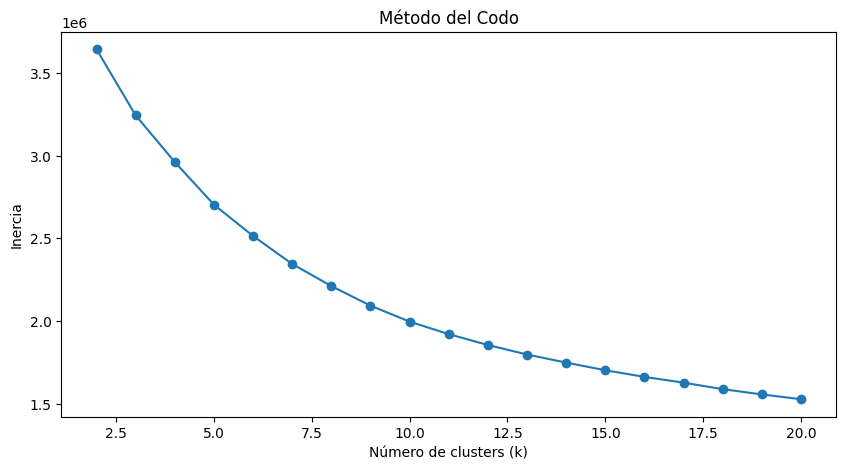

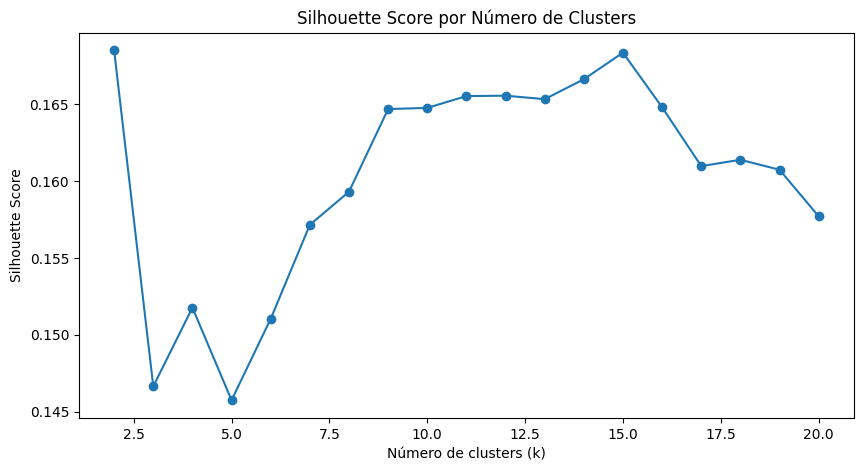

In [40]:
# Graficar el método del codo
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia[0:19], marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

#Graficar el Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()

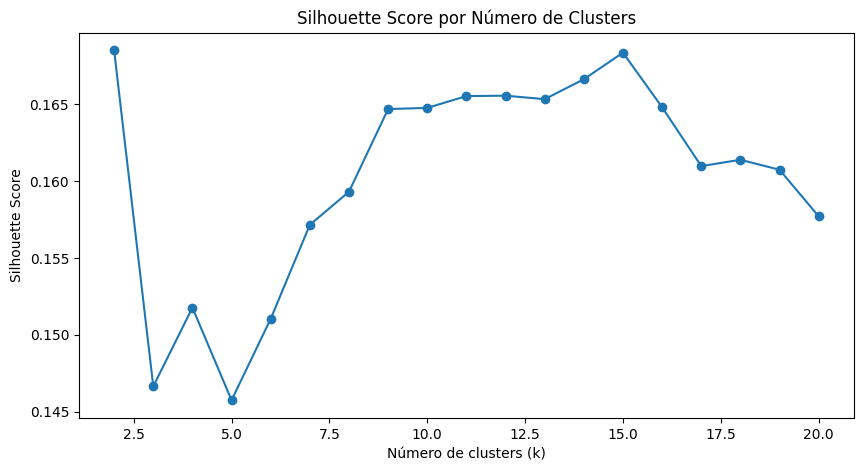

In [52]:
#Graficar el Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.show()

In [46]:
#Mostrar el mejor número de clusters
best_k = k_values[np.argmax(silhouette_scores)]
print(f"El mejor número de clusters basado en el Silhouette Score es: {best_k}")

El mejor número de clusters basado en el Silhouette Score es: 2


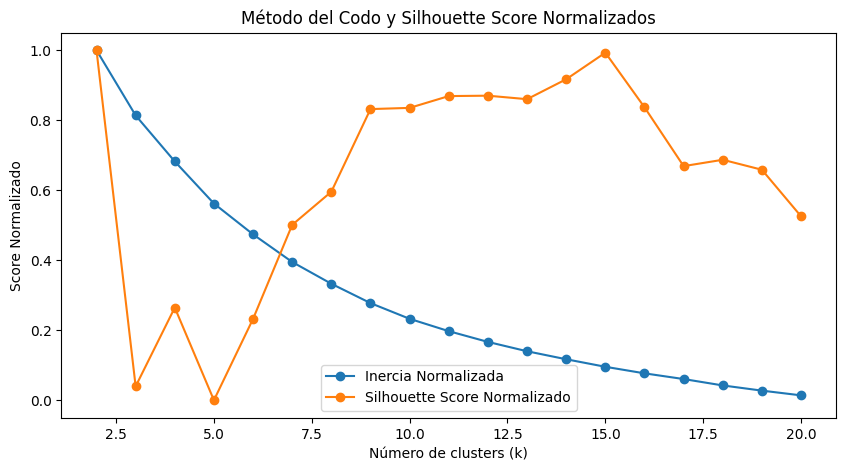

In [61]:
# Normalizar los valores de inercia y Silhouette Score
inertia_normalized = (inertia - np.min(inertia)) / (np.max(inertia) - np.min(inertia))
silhouette_scores_normalized = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))

plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_normalized[:len(k_values)], marker='o', label='Inercia Normalizada')
plt.plot(k_values, silhouette_scores_normalized, marker='o', label='Silhouette Score Normalizado')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Score Normalizado')
plt.title('Método del Codo y Silhouette Score Normalizados')
plt.legend()
plt.show()

# 6.2 Asignar los clusters a la base

Aqui probare distintas clusterizaciones

In [107]:
selected_columns = ['Probabilidad_No_Pago', 'Renta',]

data_filtered_by_columns = df_informacion_clientes_clusterizar[selected_columns]

# Normalización de los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filtered_by_columns)

# Reducción de dimensionalidad (opcional)
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
data_reduced = pca.fit_transform(data_scaled)

# Fit the KMeans model to the data
kmeans = KMeans(n_clusters=15, n_init=10, random_state=42)
kmeans.fit(data_reduced)

# Predict the clusters
clusters = kmeans.predict(data_reduced)

# Assign the predicted clusters to the dataframe
df_informacion_clientes_clusterizar['Cluster'] = clusters

# Display the dataframe with the assigned clusters
df_informacion_clientes_clusterizar.head()

,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,cantidad simulaciones,cantidad de ventas,tasa de concresion,Cluster
0,1,1,0,3,1,0.997340,0.028445,30.0,6.258183e+05,15,5,0.333333,9
1,2,0,0,1,1,0.291601,0.014320,41.0,3.172616e+05,10,2,0.200000,1
2,3,0,0,1,1,0.685085,0.002156,38.0,1.240551e+07,20,4,0.200000,0
3,4,1,0,3,1,0.914672,0.034418,57.0,5.441466e+05,25,9,0.360000,4
4,5,1,1,2,1,0.425077,0.014978,26.0,1.870225e+05,17,6,0.352941,5


In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=df_informacion_clientes_clusterizar,
    x='Renta',
    y='Probabilidad_No_Pago',
    hue='Cluster',
    palette='tab10',  # Use a palette that is less confusing
    alpha=0.6
)

# Set plot title and labels
scatter_plot.set_title('Renta vs Probabilidad No Pago')
scatter_plot.set_xlabel('Renta')
scatter_plot.set_ylabel('Probabilidad No Pago')

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# 6.5 Outliers

In [68]:
from sklearn.ensemble import IsolationForest
import numpy as np

# Crear el modelo de Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Ajustar el modelo a los datos escalados
iso_forest.fit(data_filtered_by_columns)

# Predecir los outliers
outliers = iso_forest.predict(data_filtered_by_columns)

# Convertir las predicciones a un array booleano (True para outliers, False para inliers)
outliers_bool = outliers == -1

# Contar el número de outliers
num_outliers = np.sum(outliers_bool)
print(f"Número de outliers detectados: {num_outliers}")

# Filtrar los datos para eliminar los outliers
data_filtered_by_columns_no_outliers = data_filtered_by_columns[~outliers_bool]

# Mostrar la forma de los datos antes y después de eliminar los outliers
print(f"Forma de los datos originales: {data_filtered_by_columns.shape}")
print(f"Forma de los datos sin outliers: {data_filtered_by_columns_no_outliers.shape}")

Número de outliers detectados: 5437
Forma de los datos originales: (543651, 8)
Forma de los datos sin outliers: (538214, 8)


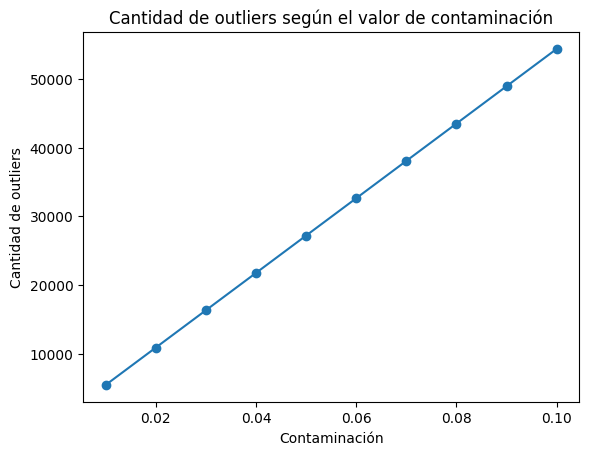

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Probar varios valores de contaminación
contamination_values = np.linspace(0.01, 0.1, 10)
outliers_count = []

for contamination in contamination_values:
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    iso_forest.fit(data_scaled)
    outliers_pred = iso_forest.predict(data_scaled)
    
    # Contar la cantidad de outliers
    num_outliers = np.sum(outliers_pred == -1)
    outliers_count.append(num_outliers)

# Graficar la cantidad de outliers encontrados
plt.plot(contamination_values, outliers_count, marker='o')
plt.xlabel('Contaminación')
plt.ylabel('Cantidad de outliers')
plt.title('Cantidad de outliers según el valor de contaminación')
plt.show()


In [70]:
import numpy as np
import pandas as pd

# Umbral para el Z-score (típicamente 3)
threshold = 3

# Calcular el Z-score para cada valor en el DataFrame
z_scores = np.abs((data_filtered_by_columns - data_filtered_by_columns.mean()) / data_filtered_by_columns.std())

# Identificar outliers: donde el Z-score es mayor que el umbral
outliers = (z_scores > threshold)

# Filtrar los outliers
data_filtered_by_columns_outliers_data = data_filtered_by_columns[outliers.any(axis=1)]  # Filtrar filas que tienen al menos un outlier
data_filtered_by_columns_clean_data = data_filtered_by_columns[~outliers.any(axis=1)]    # Filtrar las filas que no tienen outliers

# Resultados
print(f"Cantidad de outliers identificados: {data_filtered_by_columns_outliers_data.shape[0]}")


Cantidad de outliers identificados: 17179


In [71]:
import pandas as pd



# Calcular los cuartiles
Q1 = data_filtered_by_columns.quantile(0.25)
Q3 = data_filtered_by_columns.quantile(0.75)
IQR = Q3 - Q1

# Definir los límites para los outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar los outliers (valores fuera de los límites)
outliers = ((data_filtered_by_columns < lower_bound) | (data_filtered_by_columns > upper_bound))

# Filtrar los outliers
data_filtered_by_columns_outliers_data = data_filtered_by_columns[outliers.any(axis=1)]  # Filtrar filas que tienen al menos un outlier
data_filtered_by_columns_clean_data = data_filtered_by_columns[~outliers.any(axis=1)]    # Filtrar las filas que no tienen outliers

# Resultados
print(f"Cantidad de outliers identificados: {data_filtered_by_columns_outliers_data.shape[0]}")


Cantidad de outliers identificados: 62029


# 7 Clustering por politicas

In [41]:
df_simulaciones_e_informacion_de_clientes_ventas['venta'] = df_simulaciones_e_informacion_de_clientes_ventas['Unnamed: 0'].notna().astype(int)
df_simulaciones_e_informacion_de_clientes_ventas.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
df_informacion_de_clientes_clusters = df_informacion_de_clientes.copy()

In [90]:
# Calculate the 30th and 80th percentiles
percentil_30_renta = df_informacion_de_clientes['Renta'].quantile(0.30)
percentil_80_renta = df_informacion_de_clientes['Renta'].quantile(0.90)

# Define the new column based on the conditions
df_informacion_de_clientes_clusters['Separacion de renta'] = pd.cut(
    df_informacion_de_clientes_clusters['Renta'],
    bins=[-np.inf, percentil_30_renta, percentil_80_renta, np.inf],
    labels=['Renta baja', 'Renta media', 'Renta alta']
)

df_informacion_de_clientes_clusters

,Unnamed: 0,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Separacion de renta,Separacion de probabilidad no pago,Clusters caracteristicas,Clusters caracteristicas numerico
0,0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,6.258183e+05,2164276.0,7.125854e+05,Renta media,Pagador neutro,Renta media - Pagador neutro,14
1,1,2,Femenino,Cliente no Digital,Baja,Chileno,0.291601,0.014320,41.0,3.172616e+05,1451704.0,1.970697e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
2,2,3,Femenino,Cliente no Digital,Baja,Chileno,0.685085,0.002156,38.0,1.240551e+07,39322607.0,1.400604e+07,Renta alta,Muy buen pagador,Renta alta - Muy buen pagador,2
3,3,4,Masculino,Cliente no Digital,Alta,Chileno,0.914672,0.034418,57.0,5.441466e+05,1607042.0,5.159465e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
4,4,5,Masculino,Cliente Digital,Media,Chileno,0.425077,0.014978,26.0,1.870225e+05,493865.0,2.601013e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543646,543647,Femenino,Cliente Digital,Baja,Chileno,0.144657,0.037291,29.0,1.176598e+05,9625991.0,1.299826e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
543647,543647,543648,Masculino,Cliente no Digital,Baja,Chileno,0.740170,0.035877,31.0,1.558612e+06,7522126.0,1.740917e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14
543648,543648,543649,Masculino,Cliente no Digital,Media,Chileno,0.255285,0.023306,49.0,9.449508e+05,1889172.0,1.057952e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14
543649,543649,543650,Femenino,Cliente no Digital,Media,Chileno,0.709086,0.015121,40.0,1.039964e+06,4518498.0,1.010872e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14


Esto es un codigo para encontrar los cortes de probabilidad de pago basado en el grafico renta vs prob no pago

In [79]:
max_probabilidad_no_pago_list = []

for renta_threshold in np.arange(0.00e+08, 0.95e+08, 0.001e+08):
    max_probabilidad_no_pago = df_informacion_de_clientes[df_informacion_de_clientes['Renta'] >= renta_threshold]['Probabilidad_No_Pago'].max()
    max_probabilidad_no_pago_list.append(max_probabilidad_no_pago)

print(max_probabilidad_no_pago_list)

[0.0699990288956827, 0.0699986476265974, 0.0699986476265974, 0.0699980486931661, 0.0699980486931661, 0.0699944044765656, 0.0699944044765656, 0.0699917956483958, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699862176619112, 0.0699653001574927, 0.0699653001574927, 0.0699653001574927, 0.0699653001574927, 0.0699346329238024, 0.0699346329238024, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.069876280688137, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.0697840684846555, 0.069784

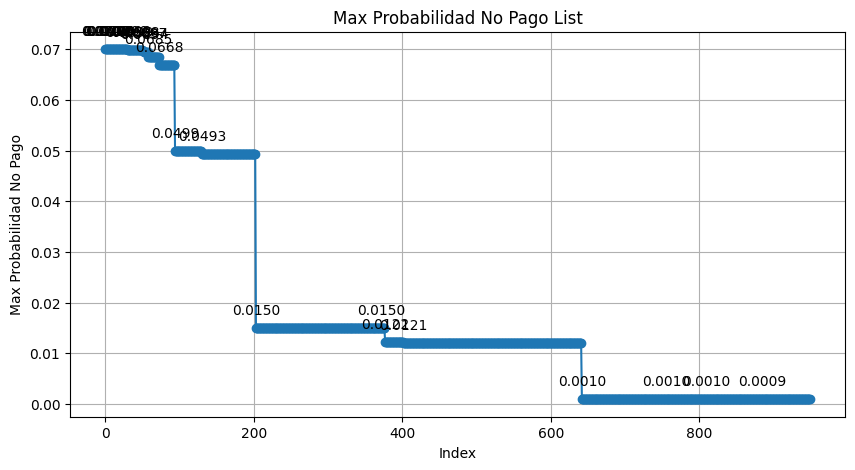

In [80]:
import matplotlib.pyplot as plt

# Plotting the max_probabilidad_no_pago_list
plt.figure(figsize=(10, 5))
plt.plot(max_probabilidad_no_pago_list, marker='o')
plt.xlabel('Index')
plt.ylabel('Max Probabilidad No Pago')
plt.title('Max Probabilidad No Pago List')
plt.grid(True)

# Annotate each point with its value only if the value before was different
previous_value = None
for i, value in enumerate(max_probabilidad_no_pago_list):
    if previous_value is None or value != previous_value:
        plt.annotate(f'{value:.4f}', (i, value), textcoords="offset points", xytext=(0,10), ha='center')
    previous_value = value

plt.show()

In [82]:
#Se establecen los cortes de la probabilidad segun lo visto arriba
corte_prob_1 = 0.06
corte_prob_2 = 0.04
corte_prob_3 = 0.014
corte_prob_4 = 0.011

# Define the new column based on the conditions
df_informacion_de_clientes_clusters['Separacion de probabilidad no pago'] = pd.cut(
    df_informacion_de_clientes_clusters['Probabilidad_No_Pago'],
    bins=[-np.inf, corte_prob_4, corte_prob_3, corte_prob_2, corte_prob_1, np.inf],
    labels=['Muy buen pagador', 'Buen pagador', 'Pagador neutro', 'Mal pagador', 'Muy mal pagador']
)
df_informacion_de_clientes_clusters

,Unnamed: 0,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Separacion de renta,Separacion de probabilidad no pago
0,0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,6.258183e+05,2164276.0,7.125854e+05,Renta media,Pagador neutro
1,1,2,Femenino,Cliente no Digital,Baja,Chileno,0.291601,0.014320,41.0,3.172616e+05,1451704.0,1.970697e+05,Renta baja,Pagador neutro
2,2,3,Femenino,Cliente no Digital,Baja,Chileno,0.685085,0.002156,38.0,1.240551e+07,39322607.0,1.400604e+07,Renta alta,Muy buen pagador
3,3,4,Masculino,Cliente no Digital,Alta,Chileno,0.914672,0.034418,57.0,5.441466e+05,1607042.0,5.159465e+05,Renta baja,Pagador neutro
4,4,5,Masculino,Cliente Digital,Media,Chileno,0.425077,0.014978,26.0,1.870225e+05,493865.0,2.601013e+05,Renta baja,Pagador neutro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543646,543647,Femenino,Cliente Digital,Baja,Chileno,0.144657,0.037291,29.0,1.176598e+05,9625991.0,1.299826e+05,Renta baja,Pagador neutro
543647,543647,543648,Masculino,Cliente no Digital,Baja,Chileno,0.740170,0.035877,31.0,1.558612e+06,7522126.0,1.740917e+06,Renta media,Pagador neutro
543648,543648,543649,Masculino,Cliente no Digital,Media,Chileno,0.255285,0.023306,49.0,9.449508e+05,1889172.0,1.057952e+06,Renta media,Pagador neutro
543649,543649,543650,Femenino,Cliente no Digital,Media,Chileno,0.709086,0.015121,40.0,1.039964e+06,4518498.0,1.010872e+06,Renta media,Pagador neutro


In [91]:
df_informacion_de_clientes_clusters['Clusters caracteristicas'] = df_informacion_de_clientes_clusters['Separacion de renta'].astype(str) + ' - ' + df_informacion_de_clientes_clusters['Separacion de probabilidad no pago'].astype(str)
# Create a new column 'Clusters caracteristicas numerico' that assigns a unique number to each unique entry in 'Clusters caracteristicas'
df_informacion_de_clientes_clusters['Clusters caracteristicas numerico'] = df_informacion_de_clientes_clusters['Clusters caracteristicas'].astype('category').cat.codes

df_informacion_de_clientes_clusters

,Unnamed: 0,rut,Genero,Categoria_Digital,Elasticidad_Precios,Nacionalidad,Propension,Probabilidad_No_Pago,Edad,Renta,Oferta_Consumo,Deuda_CMF,Separacion de renta,Separacion de probabilidad no pago,Clusters caracteristicas,Clusters caracteristicas numerico
0,0,1,Masculino,Cliente no Digital,Alta,Chileno,0.997340,0.028445,30.0,6.258183e+05,2164276.0,7.125854e+05,Renta media,Pagador neutro,Renta media - Pagador neutro,14
1,1,2,Femenino,Cliente no Digital,Baja,Chileno,0.291601,0.014320,41.0,3.172616e+05,1451704.0,1.970697e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
2,2,3,Femenino,Cliente no Digital,Baja,Chileno,0.685085,0.002156,38.0,1.240551e+07,39322607.0,1.400604e+07,Renta alta,Muy buen pagador,Renta alta - Muy buen pagador,2
3,3,4,Masculino,Cliente no Digital,Alta,Chileno,0.914672,0.034418,57.0,5.441466e+05,1607042.0,5.159465e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
4,4,5,Masculino,Cliente Digital,Media,Chileno,0.425077,0.014978,26.0,1.870225e+05,493865.0,2.601013e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543646,543646,543647,Femenino,Cliente Digital,Baja,Chileno,0.144657,0.037291,29.0,1.176598e+05,9625991.0,1.299826e+05,Renta baja,Pagador neutro,Renta baja - Pagador neutro,9
543647,543647,543648,Masculino,Cliente no Digital,Baja,Chileno,0.740170,0.035877,31.0,1.558612e+06,7522126.0,1.740917e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14
543648,543648,543649,Masculino,Cliente no Digital,Media,Chileno,0.255285,0.023306,49.0,9.449508e+05,1889172.0,1.057952e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14
543649,543649,543650,Femenino,Cliente no Digital,Media,Chileno,0.709086,0.015121,40.0,1.039964e+06,4518498.0,1.010872e+06,Renta media,Pagador neutro,Renta media - Pagador neutro,14


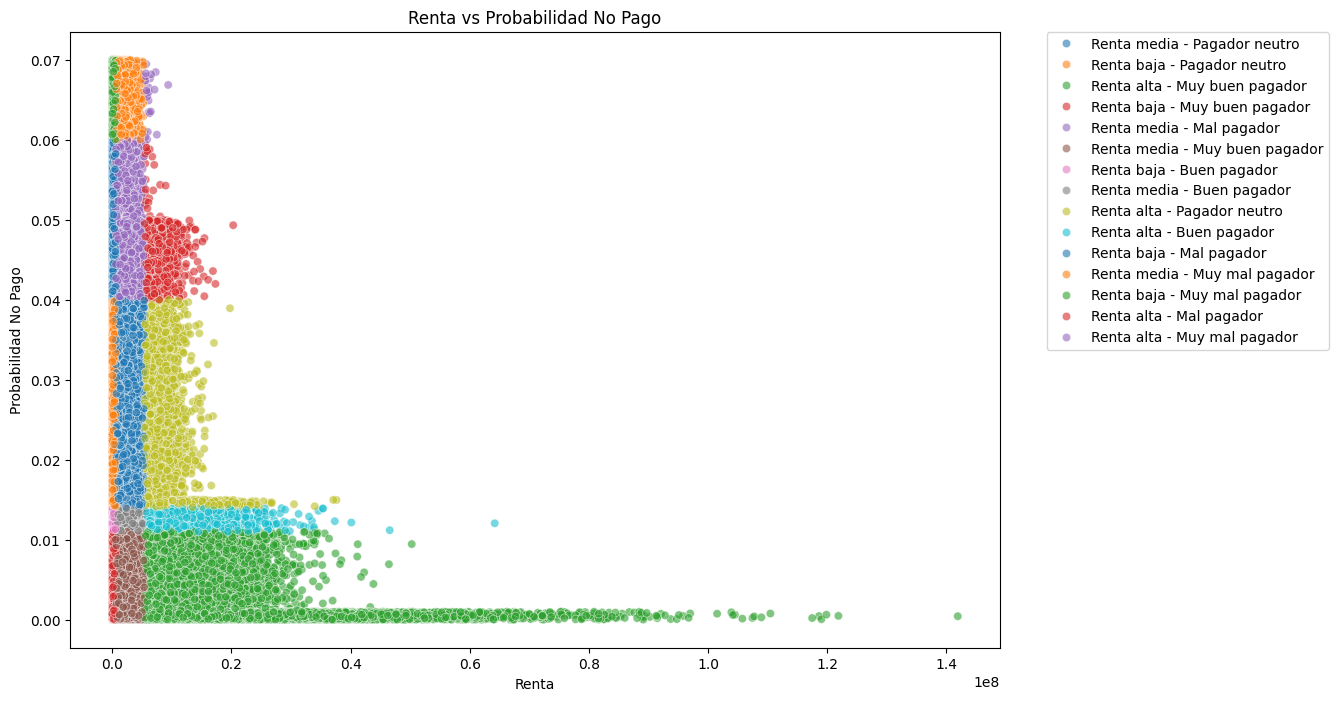

In [94]:
import seaborn as sns

import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=df_informacion_de_clientes_clusters,
    x='Renta',
    y='Probabilidad_No_Pago',
    hue='Clusters caracteristicas',
    palette='tab10',  # Use a palette that is less confusing
    alpha=0.6
)

# Set plot title and labels
scatter_plot.set_title('Renta vs Probabilidad No Pago')
scatter_plot.set_xlabel('Renta')
scatter_plot.set_ylabel('Probabilidad No Pago')

# Show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()